[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/FMLPRec.ipynb)

> This notebook runs FMLP-Rec on MovieLens1M dataset. We'll use YouTubeDNN for generating candidates and FMLP-Rec for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for retrieval](#section-0)
* [Train retrieve model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)
* [Train rank model and predict](#section-3)

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! pip install faiss-cpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (1704/1704), done.
remote: Compressing objects: 100% (1269/1269), done.
remote: Total 1704 (delta 682), reused 1309 (delta 383), pack-reused 0
Receiving objects: 100% (1704/1704), 20.92 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (682/682), done.
     |████████████████████████████████| 8.6 MB 15.2 MB/s 


In [2]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-04-15 22:57:04--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  3.45MB/s    in 1.6s    

2022-04-15 22:57:06 (3.45 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [3]:
import sys
sys.path.append('./HandyRec/')

In [4]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import PointWiseDataset, PairWiseDataset

from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.models.retrieval import YouTubeMatchDNN
from handyrec.models.ranking import FMLPRec
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
RETRIEVAL_EMBEDDING_DIM = 64
RANK_EMBEDDING_DIM = 64
SEQ_LEN = 40
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1
NEG_NUM = 10
CANDIDATE_NUM = 100

**Load MovieLens1M data**

In [7]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', SEQ_LEN)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:10<00:00, 552.23it/s] 


# 0. Prepare data for retrieval<a name="section-0"></a>

In [8]:
user_features = ['user_id', 'gender', 'occupation']
item_features = ['movie_id','genres']
inter_features = ['hist_movie']

In [9]:
retrieval_dataset = PointWiseDataset(
    "RetrievalDataset",
    task="retrieval",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

retrieval_dataset.train_test_split(TEST_NUM)
retrieval_dataset.train_valid_split(VALID_RATIO)
retrieval_dataset.gen_dataset(user_features, item_features, inter_features, shuffle=False)

Save inter features: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


In [10]:
train_data, valid_data, test_data, test_label = retrieval_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE
)

Load inter features: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


In [11]:
feature_dim = retrieval_dataset.get_feature_dim(user_features, item_features, [])

# 1. Train retrieve model and export embeddings <a name="section-1"></a>

In [12]:
feat_pool1 = FeaturePool()

In [13]:
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in item_features}

retrieve_item_features = [SparseFeature('movie_id', feature_dim['movie_id'], RETRIEVAL_EMBEDDING_DIM)] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, RETRIEVAL_EMBEDDING_DIM), 'genres',6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=retrieve_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_model_input,
    embd_dim=RETRIEVAL_EMBEDDING_DIM
)

In [14]:
retrieve_user_features = [SparseFeature(x, feature_dim[x], RETRIEVAL_EMBEDDING_DIM) for x in user_features] +\
                [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], RETRIEVAL_EMBEDDING_DIM), 'hist_movie', SEQ_LEN)]
user_feature_group = FeatureGroup('user', retrieve_user_features, feat_pool1)

In [15]:
retrieve_model = YouTubeMatchDNN(
    user_feature_group, item_feature_group,
    dnn_hidden_units=(512,256,RETRIEVAL_EMBEDDING_DIM), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=CANDIDATE_NUM
)

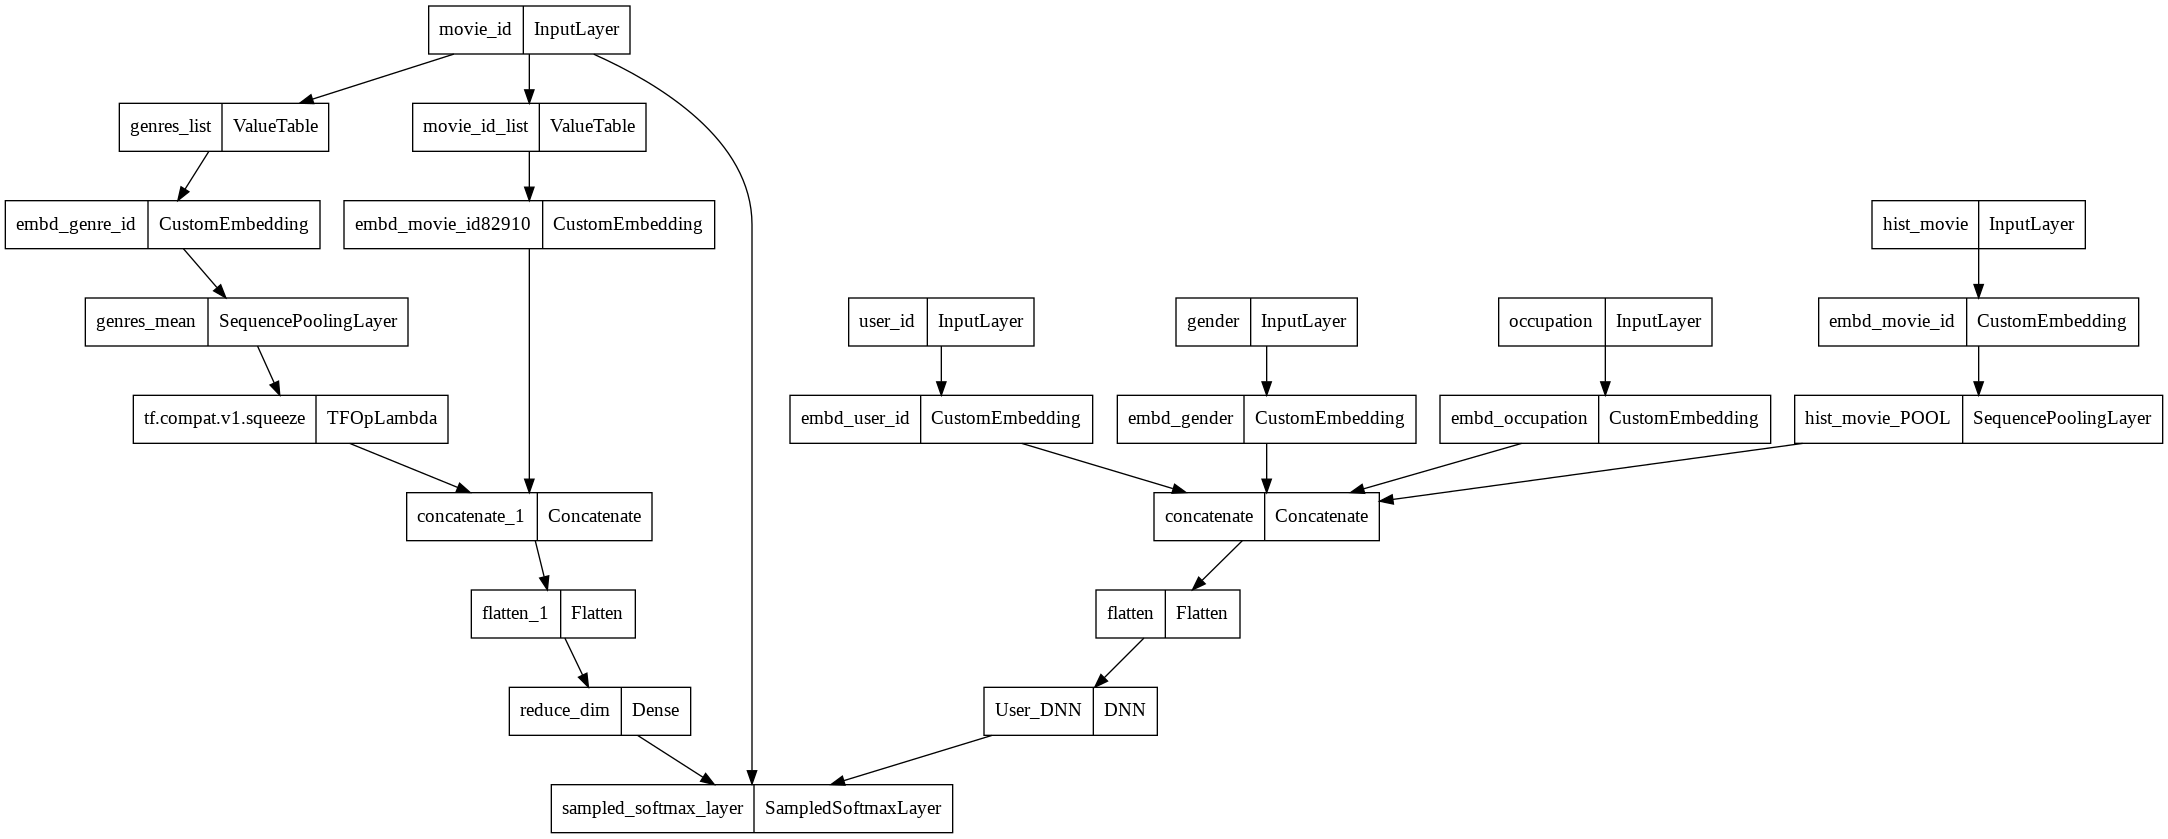

In [16]:
plot_model(retrieve_model)

In [17]:
retrieve_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./retrieve_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = retrieve_model.fit(
    x=train_data,
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop, checkpoint],
)

Epoch 1/50
114/114 [==============================] - 9s 35ms/step - loss: 3.9578 - val_loss: 3.9591
Epoch 2/50
114/114 [==============================] - 4s 31ms/step - loss: 3.8672 - val_loss: 3.9456
Epoch 3/50
114/114 [==============================] - 4s 31ms/step - loss: 3.2294 - val_loss: 3.4498
Epoch 4/50
114/114 [==============================] - 4s 31ms/step - loss: 2.4984 - val_loss: 2.8541
Epoch 5/50
114/114 [==============================] - 4s 31ms/step - loss: 2.2592 - val_loss: 2.4204
Epoch 6/50
114/114 [==============================] - 4s 32ms/step - loss: 2.1357 - val_loss: 2.2819
Epoch 7/50
114/114 [==============================] - 4s 32ms/step - loss: 2.0199 - val_loss: 2.0028
Epoch 8/50
114/114 [==============================] - 4s 33ms/step - loss: 1.9357 - val_loss: 1.9126
Epoch 9/50
114/114 [==============================] - 4s 31ms/step - loss: 1.7624 - val_loss: 1.9193
Epoch 10/50
114/114 [==============================] - 4s 31ms/step - loss: 1.7618 - val_lo

In [18]:
retrieve_model.load_weights('./retrieve_checkpoint/')

In [19]:
user_embedding_model = Model(inputs=retrieve_model.user_input, outputs=retrieve_model.user_embedding)
item_embedding_model = Model(inputs=retrieve_model.item_input, outputs=retrieve_model.item_embedding)

user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(5923, 64)
(3883, 64)


# 2. Use Faiss to generate candidates <a name="section-2"></a>

## Test retrieve model

In [20]:
candidates = search_embedding(
    RETRIEVAL_EMBEDDING_DIM, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

In [21]:
map_at_k(test_label, candidates, k=10)

0.011700647730531238

In [22]:
recall_at_k(test_label, candidates, k=10)

0.030373121728853626

In [23]:
recall_at_k(test_label, candidates, k=100)

0.1351848725308121

## Prepare data for ranking

In [24]:
test_user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
test_candidates = search_embedding(
    RETRIEVAL_EMBEDDING_DIM, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

test_candidates = {
    test_data['user_id'][i] : test_candidates[i]
    for i in range(test_candidates.shape[0])
}

In [25]:
del user_embs, item_embs, train_data, test_user_embs
gc.collect()

8880

In [26]:
user_features = ['user_id']
item_features = ['movie_id']
inter_features = ['hist_movie']

In [27]:
ranking_dataset = PairWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    neg_iid_name="neg_movie_id",
    threshold=4,
)

ranking_dataset.train_test_split(TEST_NUM)
ranking_dataset.negative_sampling(NEG_NUM)
ranking_dataset.train_valid_split(VALID_RATIO)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 1/1 [00:35<00:00, 35.20s/it]


In [28]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE
)

Load inter features: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


In [29]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])

# 3. Train rank model and predict <a name="section-3"></a>

In [30]:
feat_pool2 = FeaturePool()

In [31]:
rank_item_seq_features = [SparseSeqFeature(SparseFeature('movie_id', feature_dim['movie_id'], RANK_EMBEDDING_DIM), 'hist_movie', SEQ_LEN)]
item_seq_feat_group = FeatureGroup('item_seq', rank_item_seq_features, feat_pool2)

In [32]:
rank_model = FMLPRec(
    item_seq_feat_group,
    dropout=0.5,
    block_num=3
)

In [33]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4, clipvalue=1.), loss=None)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50
1132/1132 [==============================] - 243s 210ms/step - loss: 0.9472 - val_loss: 0.8545
Epoch 2/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.6435 - val_loss: 0.3980
Epoch 3/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.3298 - val_loss: 0.2333
Epoch 4/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.2276 - val_loss: 0.1830
Epoch 5/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.1899 - val_loss: 0.1596
Epoch 6/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.1697 - val_loss: 0.1444
Epoch 7/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.1575 - val_loss: 0.1351
Epoch 8/50
1132/1132 [==============================] - 239s 211ms/step - loss: 0.1493 - val_loss: 0.1278
Epoch 9/50
1132/1132 [==============================] - 240s 212ms/step - loss: 0.1430 - val_loss: 0.1227
Epoch 10/50
1132/1132 [=======================

In [34]:
rank_model.load_weights('./rank_checkpoint/')
pred_model = Model(inputs=rank_model.real_inputs, outputs=rank_model.real_outputs)

In [35]:
del train_data
gc.collect()

2843

In [36]:
pred = pred_model.predict(test_data, batch_size=BATCH_SIZE)

In [37]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [38]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [39]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [40]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.02545580317781905

In [41]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.05924362654060442

In [42]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.1351848725308121